# Imports

In [10]:
import pandas as pd
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score

from feature_light import get_feature
from net1_light import AudioClassifier
from data_loader_light import get_dataloader
import utils

In [11]:
import warnings
warnings.filterwarnings('ignore')

# Config

In [12]:
class Config:
    SR = 32000
    
    # Dataset
    ROOT_META = "train_final.csv"
    # weight 저장용 폴더의 path(없으면 만드셈)
    WEIGHT_DIR = "model_weight"

    # Training
    BATCH_SIZE = 2
    N_EPOCHS = 2
    LR = 1e-4
    
    # Others
    SEED = 42
    SERIAL = utils.get_serial()
    USE_RATIO = 0.001 # 사용 할 데이터 양
    
CONFIG = Config()

utils.seed_everything(CONFIG.SEED) # Seed 고정
utils.ensure_directory_exists(f"{CONFIG.WEIGHT_DIR}/{CONFIG.SERIAL}")
utils.save_config(CONFIG)

Directory model_weight/20240717172532 created.


In [13]:
whole_df = pd.read_csv(CONFIG.ROOT_META)
whole_df = whole_df.sample(frac=CONFIG.USE_RATIO, random_state=CONFIG.SEED)
print(f"use {whole_df.shape[0]}")
whole_df.head(3)

use 75


,id,path,label1,label2,len
23868,JMHIXMCS,./train/JMHIXMCS.ogg,real,real,2472.0
69305,XMYROWVY_WFKWTDNS,./validate_two_voice/XMYROWVY_WFKWTDNS.ogg,real,real,4771.0
40760,ZFIBLNNV,./train/ZFIBLNNV.ogg,real,real,5424.0


In [14]:
# train_data := list of (cnn_feature, rnn_feature)
# cnn_feature := image_sequence, each image is of shape (224, 224, 6)
# rnn_feature := feature of shape (Value depending on the sound file, 67)
train_data_df = whole_df[whole_df['path'].str.contains('train')]
validate_data_df = whole_df[whole_df['path'].str.contains('validate')]
print(f"The number of train_data_df   : {train_data_df.shape[0]}")
print(f"The number of validate_data_df: {validate_data_df.shape[0]}")

train_data, train_labels = get_feature(df=train_data_df, train_mode=True)
validate_data, val_labels = get_feature(df=validate_data_df, train_mode=True)
cnn_channel_num = train_data[0][0][0].shape[-1]
rnn_feature_num = train_data[0][1].shape[-1]

The number of train_data_df   : 49
The number of validate_data_df: 23
preprocessing cnn feature


49it [00:14,  3.30it/s]


preprocessing rnn feature


49it [00:02, 18.50it/s]


preprocessing cnn feature


10it [00:02,  4.31it/s]


KeyboardInterrupt: 

<Figure size 224x224 with 0 Axes>

# Dataset

In [7]:
train_loader = get_dataloader(dataset=train_data, labels=train_labels, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
val_loader = get_dataloader(dataset=validate_data, labels=val_labels, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

# Train & Validation

In [8]:
def train(model, optimizer, scheduler, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.BCELoss().to(device)
    
    result = pd.DataFrame(columns=['epoch', 'Train_Loss', 'Val_Loss', 'Val_AUC', 'lr'])
    best_val_score = 0
    best_model = None
    
    for epoch in range(1, CONFIG.N_EPOCHS+1):
        model.train()
        train_loss = []
        for x_cnn, x_len_cnn, x_rnn, x_len_rnn, labels in tqdm(train_loader):
            # x_cnn.shape     := (CONFIG.BATCH_SIZE, mini batch에서 길이가 가장 긴 image_sequence의 길이, 6, 224, 224)
            # x_len_cnn.shape := (CONFIG.BATCH_SIZE)
            x_cnn = x_cnn.float().to(device)
            x_rnn = x_rnn.float().to(device)
            labels = labels.float().to(device)
            
            optimizer.zero_grad()
            
            output = model(x_cnn, x_len_cnn, x_rnn, x_len_rnn)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss.append(loss.item())

        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val AUC : [{_val_score:.5f}]')
        result.loc[epoch] =[f"{epoch}", f"{_train_loss:.5f}", f"{_val_loss:.5f}", f"{_val_score:.5f}", f"{scheduler.get_last_lr()[0]}"]

        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
        
        # save weight
        tmp = CONFIG.WEIGHT_DIR+f"/{CONFIG.SERIAL}/{epoch}.pth"
        print(f"saving {tmp}")
        torch.save(model.state_dict(), tmp)
    
    print(f"saving best model and result")
    torch.save(best_model.state_dict(), CONFIG.WEIGHT_DIR+f"/{CONFIG.SERIAL}/best.pth")
    result.to_csv(CONFIG.WEIGHT_DIR+f"/{CONFIG.SERIAL}/result.csv", index=False)
    return best_model

def multiLabel_AUC(y_true, y_scores):
    auc_scores = []
    for i in range(y_true.shape[1]):
        auc = roc_auc_score(y_true[:, i], y_scores[:, i])
        auc_scores.append(auc)
    mean_auc_score = np.mean(auc_scores)
    return mean_auc_score
    
def validation(model, criterion, val_loader, device):
    print("validating")
    model.eval()
    val_loss, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for x_cnn, x_len_cnn, x_rnn, x_len_rnn, labels in tqdm(val_loader):
            # x_cnn.shape     := (CONFIG.BATCH_SIZE, mini batch에서 길이가 가장 긴 image_sequence의 길이, 6, 224, 224)
            # x_len_cnn.shape := (CONFIG.BATCH_SIZE)
            x_cnn = x_cnn.float().to(device)
            x_rnn = x_rnn.float().to(device)
            labels = labels.float().to(device)
            
            probs = model(x_cnn, x_len_cnn, x_rnn, x_len_rnn)
            loss = criterion(probs, labels)
            
            val_loss.append(loss.item())

            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
        
        _val_loss = np.mean(val_loss)

        all_labels = np.concatenate(all_labels, axis=0)
        all_probs = np.concatenate(all_probs, axis=0)
        
        # Calculate AUC score
        auc_score = multiLabel_AUC(all_labels, all_probs)
    
    return _val_loss, auc_score

## Run

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = AudioClassifier(cnn_channel_num=cnn_channel_num, rnn_feature_num=rnn_feature_num)
optimizer = torch.optim.Adam(params = model.parameters(), lr = CONFIG.LR)

# 데이터 병렬 처리
if torch.cuda.device_count() > 1:
    print(f"using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model.to(device)
print(f"Using device: {device}")

criterion = nn.BCELoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=CONFIG.LR)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CONFIG.LR, steps_per_epoch=len(train_loader), epochs=CONFIG.N_EPOCHS)

best_model = train(model, optimizer, scheduler, train_loader, val_loader, device)

Using device: cpu


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([2, 512])
torch.Size([2, 512])


  4%|▍         | 1/25 [00:21<08:36, 21.53s/it]

torch.Size([2, 512])
torch.Size([2, 512])


  8%|▊         | 2/25 [00:23<03:49,  9.98s/it]

torch.Size([2, 512])
torch.Size([2, 512])


  8%|▊         | 2/25 [00:38<07:28, 19.48s/it]


KeyboardInterrupt: 

## visualize

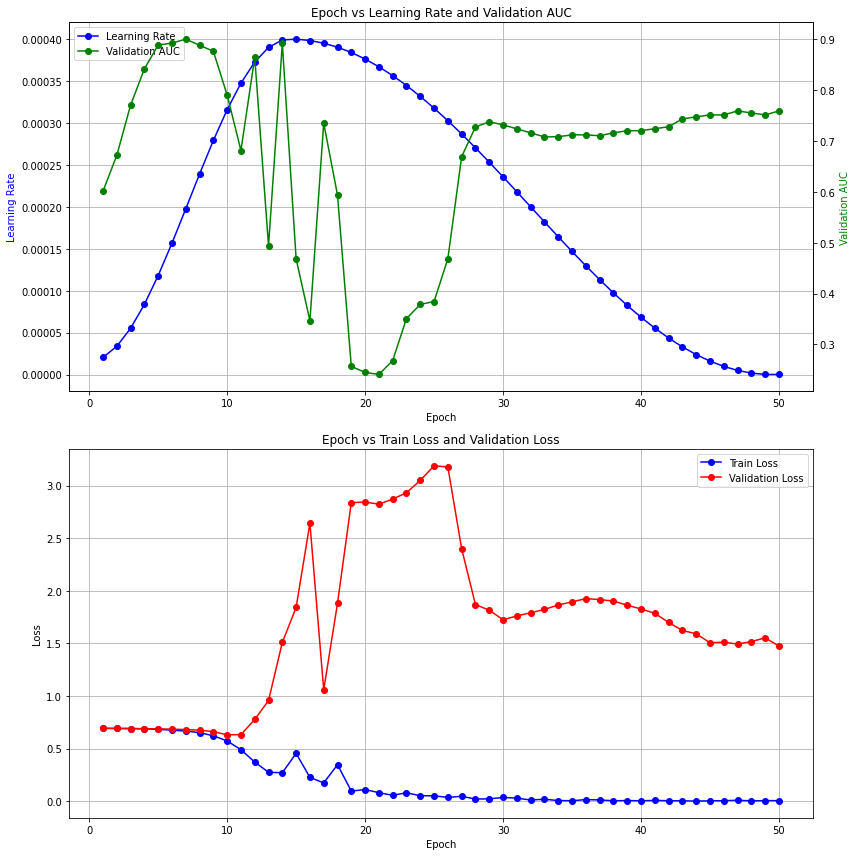

In [18]:
df = pd.read_csv(CONFIG.WEIGHT_DIR+f"/{CONFIG.SERIAL}/result.csv")

plt.figure(figsize=(12, 12))

# epoch vs lr 및 epoch vs Val_AUC 시각화 (다른 y축 사용)
ax1 = plt.subplot(2, 1, 1)
ax2 = ax1.twinx()

ax1.plot(df['epoch'], df['lr'], marker='o', label='Learning Rate', color='blue')
ax2.plot(df['epoch'], df['Val_AUC'], marker='o', label='Validation AUC', color='green')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Learning Rate', color='blue')
ax2.set_ylabel('Validation AUC', color='green')
ax1.set_title('Epoch vs Learning Rate and Validation AUC')
ax1.grid(True)

# Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# epoch vs Train_Loss 및 epoch vs Val_Loss 시각화 (같은 플롯)
plt.subplot(2, 1, 2)
plt.plot(df['epoch'], df['Train_Loss'], marker='o', label='Train Loss', color='blue')
plt.plot(df['epoch'], df['Val_Loss'], marker='o', label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Train Loss and Validation Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Inference

In [ ]:
test = pd.read_csv('./test.csv')
test_feature = get_feature(test, train_mode=False)
test_loader = get_dataloader(dataset=test_feature, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

preprocessing feature using 16 number of cpu


  0%|          | 195/50000 [01:41<7:57:17,  1.74it/s] 

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for x_cnn, x_len_cnn, x_rnn, x_len_rnn in tqdm(iter(test_loader)):
            x_cnn = x_cnn.float().to(device)
            x_rnn = x_rnn.float().to(device)
            
            probs = model(x_cnn, x_len_cnn, x_rnn, x_len_rnn)

            probs  = probs.cpu().detach().numpy()
            predictions += probs.tolist()
    return predictions

In [ ]:
preds = inference(best_model, test_loader, device)

## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit.iloc[:, 1:] = preds
submit.head(3)

In [ ]:
path = CONFIG.WEIGHT_DIR+f"/{CONFIG.SERIAL}/submit.csv"
print(f"saving {path}")
submit.to_csv(path, index=False)